# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [3]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [33]:
train_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"), reflect_z=False,
                             input_pipe=input_pipe, rot_mult=8)

Augmenting via phi rotations
Augmenting via x flips
Total augmentation multiplicity is 16


/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


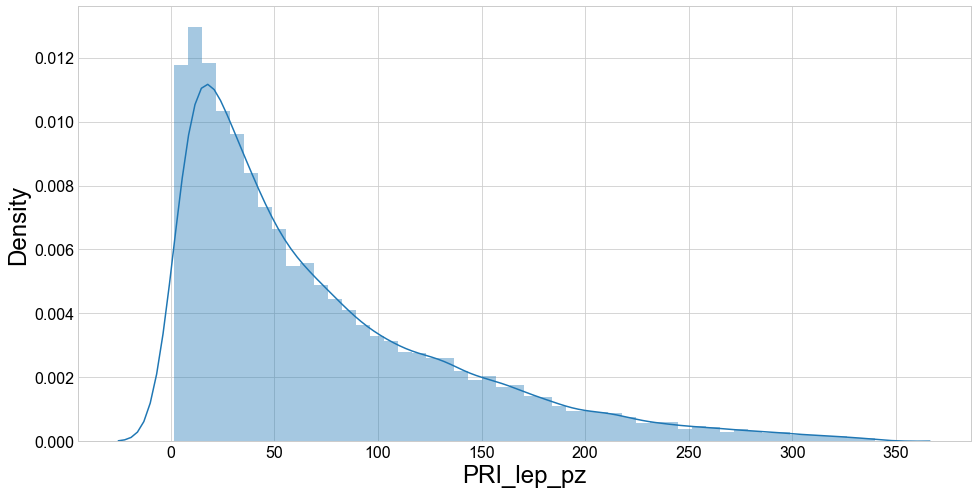

In [34]:
data = pd.DataFrame(input_pipe.inverse_transform(np.array(train_fy.source['fold_0/inputs'])), columns=train_feats)
plot_feat(data, 'PRI_lep_pz')

## Determine LR

2 classes found, running in binary mode



/Users/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 11.021s 


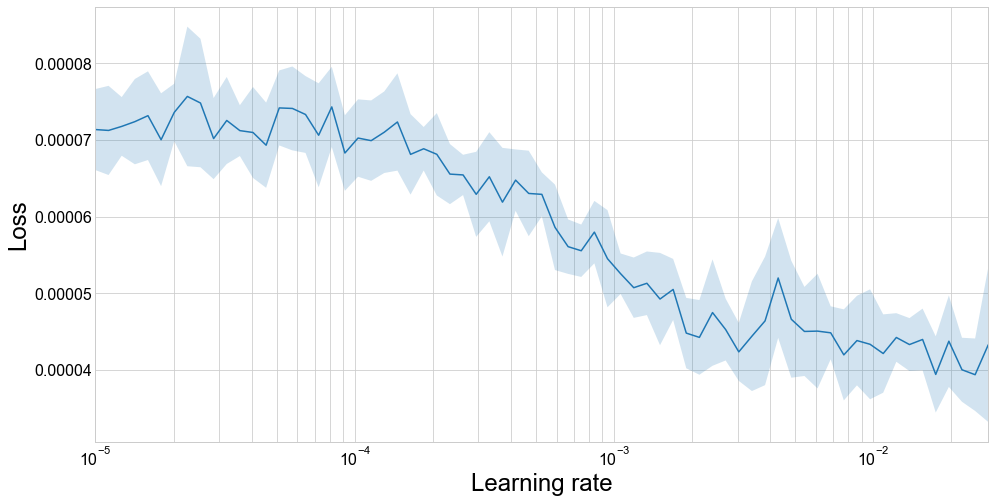

______________________________________



In [13]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [35]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode

1 New best found: 3.906909373181407e-05
2 New best found: 3.6987414295435886e-05
3 New best found: 3.534375143644866e-05
5 New best found: 3.4554617255344055e-05
6 New best found: 3.4230848267907274e-05
7 New best found: 3.418325303064194e-05
10 New best found: 3.4031553723616526e-05
11 New best found: 3.3762222100631336e-05
13 New best found: 3.331157616630662e-05
14 New best found: 3.3214426155609544e-05
15 New best found: 3.319403816567501e-05
22 New best found: 3.3045442882576024e-05
23 New best found: 3.282026650995249e-05
24 New best found: 3.28070024959743e-05
26 New best found: 3.2706679354305377e-05
27 New best found: 3.265862485714024e-05
29 New best found: 3.253905457968358e-05
31 New best found: 3.251559110940434e-05
46 New best found: 3.2434407623077275e-05
47 New best found: 3.2174656738061456e-05
52 New best found: 3.2150821668619756e-05
56 New best found: 3.20

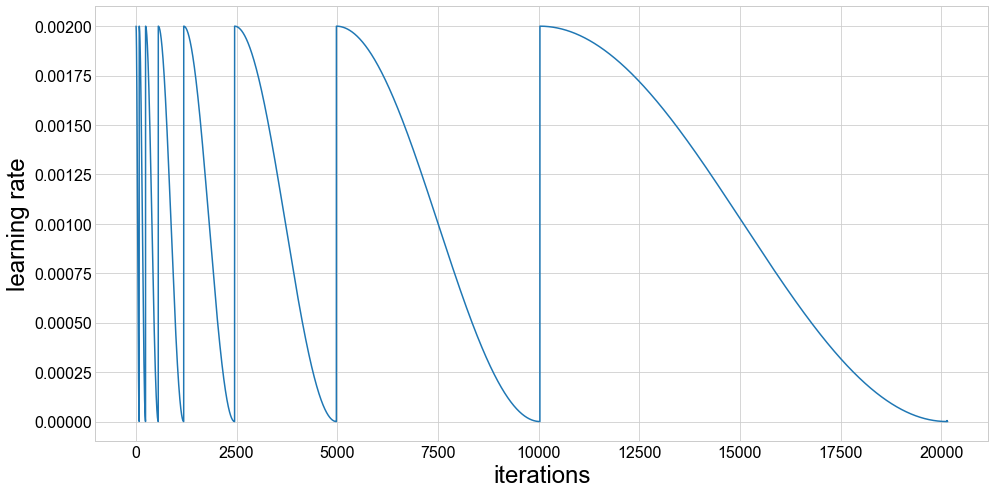

Fold took 142.916s

Training model 2 / 10
Using cosine LR annealing
1 New best found: 3.843135861196356e-05
2 New best found: 3.608679914738203e-05
3 New best found: 3.5415059347612944e-05
4 New best found: 3.4973987504869515e-05
5 New best found: 3.426421902437296e-05
6 New best found: 3.38898854857305e-05
7 New best found: 3.378269419722926e-05
10 New best found: 3.339342819847823e-05
12 New best found: 3.308243533112189e-05
13 New best found: 3.296029985799345e-05
14 New best found: 3.287397869961894e-05
20 New best found: 3.286633928774833e-05
22 New best found: 3.27953910079373e-05
23 New best found: 3.272670591275936e-05
24 New best found: 3.2698159094349244e-05
25 New best found: 3.25382765095751e-05
26 New best found: 3.2501460423084376e-05
28 New best found: 3.242749133859372e-05
29 New best found: 3.2420694199129345e-05
30 New best found: 3.241799033845956e-05
31 New best found: 3.240105445821105e-05
42 New best found: 3.222074202369689e-05
53 New best found: 3.21481123539044

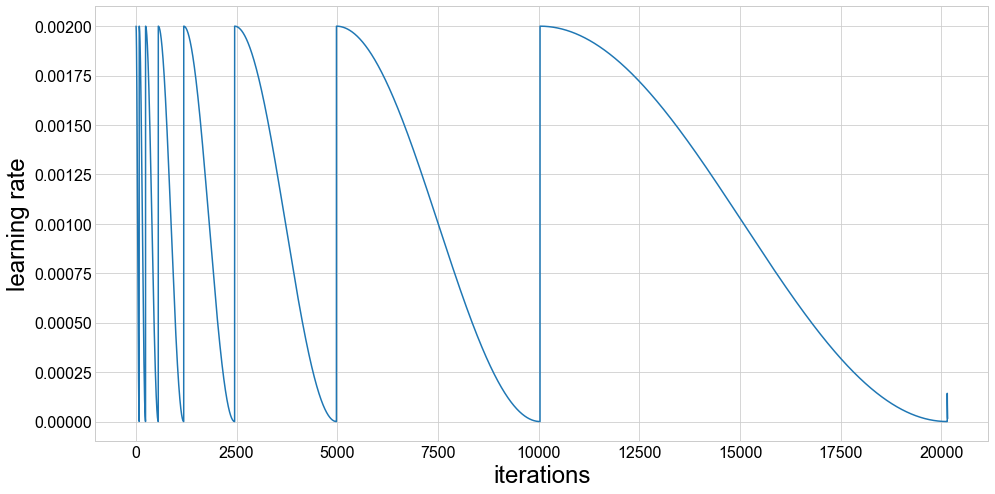

Fold took 145.552s

Training model 3 / 10
Using cosine LR annealing
1 New best found: 3.8996482549185645e-05
2 New best found: 3.607360521413474e-05
3 New best found: 3.544856648700219e-05
5 New best found: 3.446494600606755e-05
6 New best found: 3.406294164036707e-05
7 New best found: 3.3675763675808604e-05
11 New best found: 3.347250765384183e-05
12 New best found: 3.3248091391327595e-05
13 New best found: 3.2956651843177906e-05
14 New best found: 3.285640573605673e-05
15 New best found: 3.2829008728250524e-05
22 New best found: 3.279648160985408e-05
23 New best found: 3.278247444660434e-05
25 New best found: 3.2544015864385135e-05
26 New best found: 3.234780973616862e-05
27 New best found: 3.22880400091752e-05
28 New best found: 3.222665287701716e-05
29 New best found: 3.219248940700117e-05
30 New best found: 3.2174805034801707e-05
31 New best found: 3.217375660846641e-05
51 New best found: 3.210960075527595e-05
52 New best found: 3.193305429084873e-05
54 New best found: 3.192096647

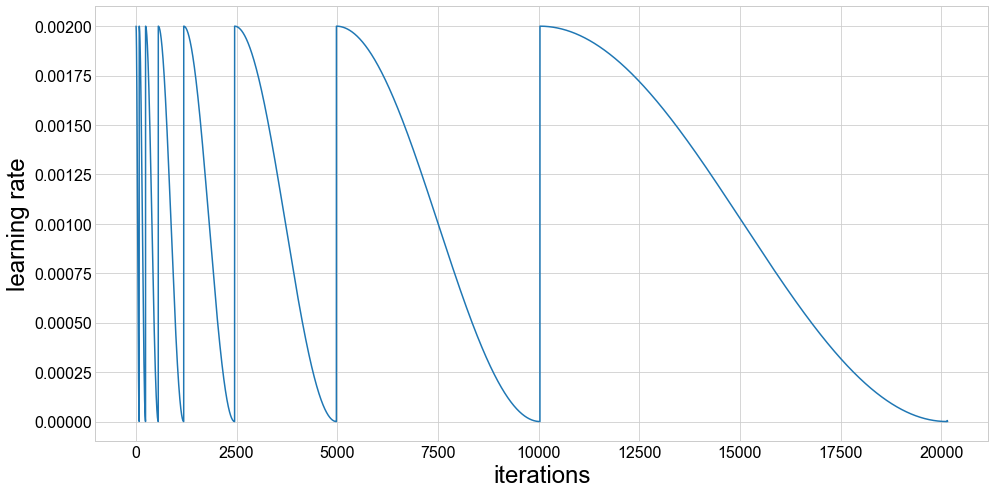

Fold took 149.306s

Training model 4 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101688). Check your callbacks.
  % delta_t_median)


1 New best found: 4.062942691380158e-05
2 New best found: 3.706700980110327e-05
3 New best found: 3.619363040052122e-05
5 New best found: 3.548424219770823e-05
6 New best found: 3.464211529790191e-05
7 New best found: 3.45135981508065e-05
8 New best found: 3.4409296557714694e-05
12 New best found: 3.38350992402411e-05
13 New best found: 3.3588087031967005e-05
14 New best found: 3.351279675989644e-05
15 New best found: 3.3492560371814764e-05
23 New best found: 3.333147427038057e-05
25 New best found: 3.313720512524014e-05
26 New best found: 3.2990170081029644e-05
27 New best found: 3.296976395940874e-05
28 New best found: 3.28487736027455e-05
29 New best found: 3.2833372642926406e-05
30 New best found: 3.282427210288006e-05
31 New best found: 3.281881283473922e-05
48 New best found: 3.276170062745223e-05
49 New best found: 3.274607826169813e-05
52 New best found: 3.267024795131874e-05
54 New best found: 3.265143920434639e-05
56 New best found: 3.2573610391409605e-05
57 New best found: 3

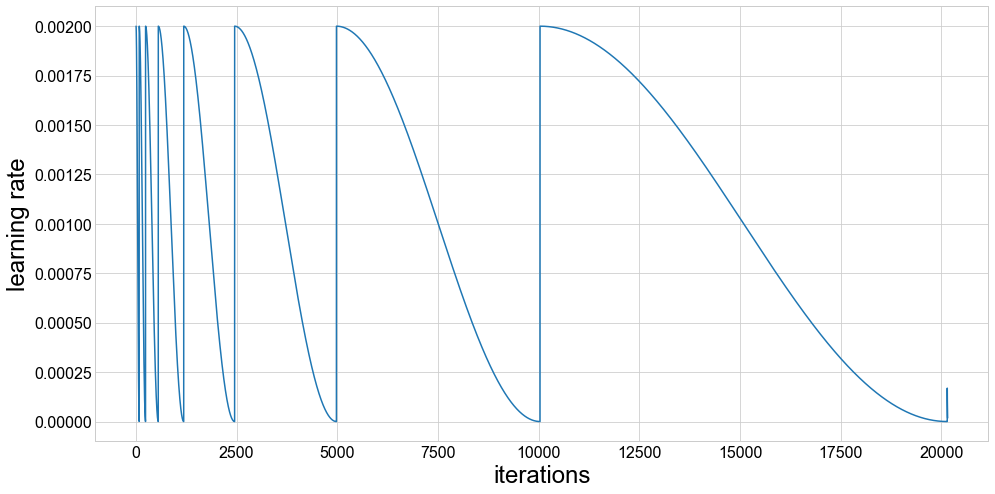

Fold took 152.322s

Training model 5 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113826). Check your callbacks.
  % delta_t_median)


1 New best found: 3.7581062118988486e-05
2 New best found: 3.54061244186596e-05
3 New best found: 3.4710700502910186e-05
4 New best found: 3.425432998337783e-05
5 New best found: 3.3788227682816796e-05
6 New best found: 3.306380023859674e-05
7 New best found: 3.298300620954251e-05
9 New best found: 3.2762404915411025e-05
10 New best found: 3.263345337909413e-05
11 New best found: 3.2506865606410426e-05
12 New best found: 3.2219396290020084e-05
13 New best found: 3.190157623175765e-05
14 New best found: 3.175128997681895e-05
15 New best found: 3.173017211665865e-05
22 New best found: 3.152321531524649e-05
25 New best found: 3.1358809740049765e-05
26 New best found: 3.1275899574393405e-05
27 New best found: 3.1252414046321065e-05
28 New best found: 3.109125994669739e-05
49 New best found: 3.0960283700551375e-05
51 New best found: 3.089840374595951e-05
52 New best found: 3.0862875914317555e-05
54 New best found: 3.083600774989463e-05
55 New best found: 3.076376206445275e-05
59 New best fo

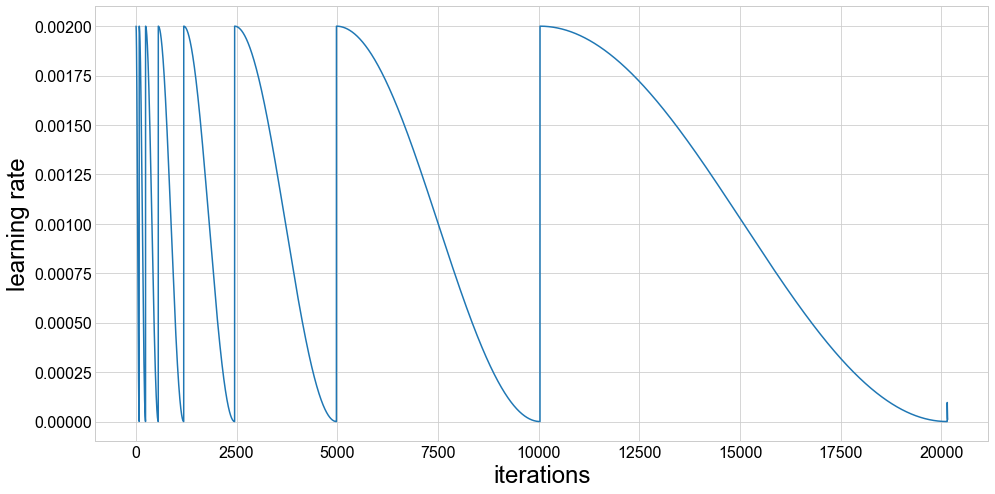

Fold took 155.605s

Training model 6 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.115331). Check your callbacks.
  % delta_t_median)


1 New best found: 3.939620420063006e-05
2 New best found: 3.8162264907714795e-05
3 New best found: 3.641289733841516e-05
5 New best found: 3.5307589280681115e-05
6 New best found: 3.4721588692014016e-05
7 New best found: 3.4606674602815673e-05
11 New best found: 3.4238061494157836e-05
12 New best found: 3.3879166808121446e-05
13 New best found: 3.371999706145551e-05
14 New best found: 3.3634092333868955e-05
15 New best found: 3.360681873691528e-05
22 New best found: 3.3374636123175615e-05
24 New best found: 3.3253623937625214e-05
26 New best found: 3.307579412868301e-05
27 New best found: 3.303109359146592e-05
28 New best found: 3.296662540396756e-05
29 New best found: 3.2889260028779545e-05
43 New best found: 3.2858636844743325e-05
48 New best found: 3.278177944283364e-05
49 New best found: 3.273884525010692e-05
51 New best found: 3.2688183189089036e-05
52 New best found: 3.2542008631793666e-05
55 New best found: 3.2460530514742675e-05
61 New best found: 3.244736316269555e-05
62 New b

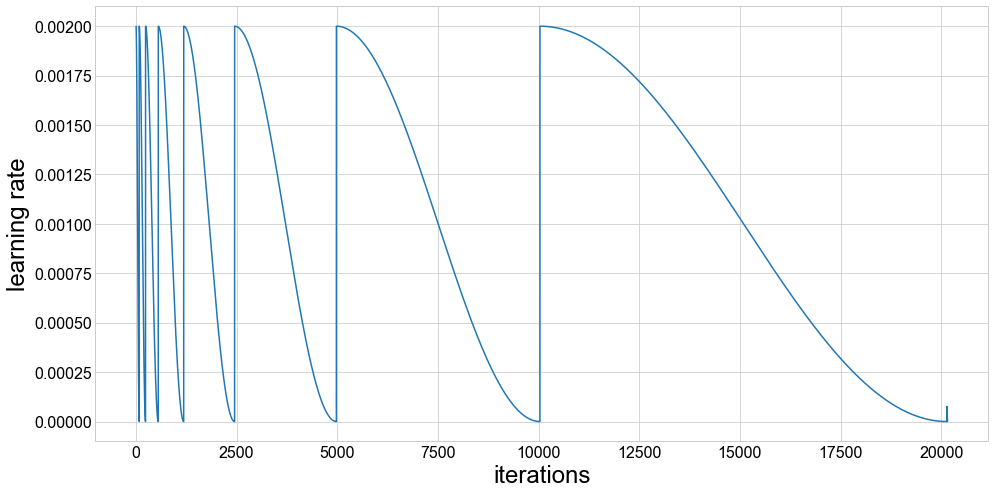

Fold took 169.768s

Training model 7 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124292). Check your callbacks.
  % delta_t_median)


1 New best found: 4.0334519391623335e-05
2 New best found: 3.679165391534821e-05
3 New best found: 3.5827332289025256e-05
4 New best found: 3.5382019405744773e-05
5 New best found: 3.468199687800544e-05
6 New best found: 3.425698807410663e-05
7 New best found: 3.41511378472585e-05
10 New best found: 3.3917344483386716e-05
11 New best found: 3.385721953052062e-05
12 New best found: 3.3589775258248175e-05
13 New best found: 3.3388854808886184e-05
14 New best found: 3.3292142052082464e-05
15 New best found: 3.3274306397707255e-05
23 New best found: 3.2979193396449134e-05
24 New best found: 3.2784170361150286e-05
26 New best found: 3.2696162690214734e-05
28 New best found: 3.26377974576276e-05
29 New best found: 3.2546404280926746e-05
30 New best found: 3.2531943975064915e-05
31 New best found: 3.253088922242742e-05
51 New best found: 3.243233235677771e-05
53 New best found: 3.235610405728764e-05
54 New best found: 3.2338408560725095e-05
56 New best found: 3.2301918715314654e-05
57 New bes

In [ ]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

The impact of data augmentation is pretty clear. Comparing the training here to that of the the CRL Swish model without augmentation we can see that we effectively gain another LR cycles worth of training epochs before we start overfitting, which allows the networks to reach much lower looses (3.18e-5 c.f. 3.23e-5) and a higher AMSs (3.98 c.f. 3.71)

## Construct ensemble

In [ ]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [ ]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

## Response on validation data without TTA

In [ ]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [ ]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

In [ ]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source)),
                                                           roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source), sample_weight=get_feature('weights', val_fy.source))))

In [ ]:
ams_scan_slow(convert_to_df(val_fy.source), br=10, w_factor=250000/50000)

In [ ]:
%%time
bootstrap_mean_calc_ams(convert_to_df(val_fy.source), br=10, w_factor=250000/50000, N=512)

With test-time augmentation we improve on 4_Model_Swish_Cyclical-LR in all metrics on validation data: overall AMS 3.77->3.90, AMS corresponding to mean cut 3.72->3.89.

## Response on validation data with TTA

In [ ]:
val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"), input_pipe=input_pipe,
                                  rotate = True, reflect = True, rot_mult=8)

In [ ]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

In [ ]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source)),
                                                           roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source), sample_weight=get_feature('weights', val_fy.source))))

In [ ]:
ams_scan_slow(convert_to_df(val_fy.source), br=10, w_factor=250000/50000)

In [ ]:
%%time
bootstrap_mean_calc_ams(convert_to_df(val_fy.source), br=10, w_factor=250000/50000, N=512)

Adding test-time augmentation provides further benefits: overall AMS 3.90->3.97, AMS corresponding to mean cut 3.89->3.91.

# Test scoring - Without TTA

In [ ]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [ ]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

In [ ]:
score_test_data(test_fy.source, 0.9607215095311403)

Using the cuts we optimised by bootstrapping the validation data, we end up with a private score which would have beaten the winning entry (3.817 c.f. 3.806). It would be nice if the public score were higher, though.

# Test scoring - With TTA

In [ ]:
test_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'testing.hdf5', "r+"), input_pipe=input_pipe,
                                   rotate = True, reflect = True, rot_mult=8)

In [ ]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

In [ ]:
score_test_data(test_fy.source, 0.9600071883760393)

Using the cuts we optimised by bootstrapping the validation data, we end up with a private score which would have beaten the winning entry (3.817 c.f. 3.806). It would be nice if the public score were higher, though.

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)